In [1]:
# Check RAM Memory

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  
print(ram_gb)

# Login into drive

from google.colab import drive
drive.mount('/content/drive')

# Importing "load_model"

from keras.models import load_model

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
89.63678208
Mounted at /content/drive


In [2]:
import numpy as np
from tensorflow.keras import optimizers

# Download and import data preprocessing .py file
!wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
from data_processing import data_bundle as data_bundle

# Download and import performance metrics .py file
!wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/performance_metrics.py
from performance_metrics import plot_ROC, plot_cm, plot_acc_loss
from sklearn.metrics import classification_report

# Download and import RN50 .py file
! wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/ResNet50.py
from ResNet50 import rn50_seei as rn50_class

# Download and import RN50 .py file

--2023-05-15 19:56:14--  https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3955 (3.9K) [text/plain]
Saving to: ‘data_processing.py’

data_processing.py  100%[===================>]   3.86K  --.-KB/s    in 0s      

2023-05-15 19:56:14 (68.8 MB/s) - ‘data_processing.py’ saved [3955/3955]

--2023-05-15 19:56:15--  https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/performance_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

In [3]:
# Define relevant paths for appropriately instantiating the data_bundle class
images_path_0 = "/content/drive/MyDrive/Thesis/M224A-0000/imageset_224_224.npy"
popn_path_0 = "/content/drive/MyDrive/Thesis/M224A-0000/popn_224A_0000.npy"
target_var = "gdp"

# In this case GDP has been chose
if target_var == "gdp":
  labels_path_0 = "/content/drive/MyDrive/Thesis/M224A-0000/gdp_224A_0000.npy"
  label_type = "GDPpercap"

elif target_var == "hdi":
  labels_path_0 = "/content/drive/MyDrive/Thesis/M224A-0000/hdi_224A_0000.npy"
  label_type = "HDI"

# Instantiate data_bundle object
basic_bundle = data_bundle(images_path_0, popn_path_0, labels_path_0, label_type, augmented=True)

# Preprocess data through the data_bundle class' methods
basic_bundle.normalize_images()
basic_bundle.normalize_popn()
basic_bundle.bundle_inputs()
basic_bundle.split_data(0.4,0.5,2023)
basic_bundle.augment_training_data()
basic_bundle.unbundle_and_shape_inputs()
basic_bundle.onehot_encode_labels()

# The resulting input sets are: self.X_tri, self.X_vai, self.X_tei (Images) and self.X_trp, self.X_vap, self.X_tep (Population)
# The resulting tragets are: self.y_train_onehot, self.y_val_onehot and self.y_test_onehot
# Where "self" is to be substituted by the given name to the data_bundle instance

/content/data_processing.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(list(zip(self.images, np.array(self.popn))))


### Model: ResNet50 - GDP per capita

In [11]:
# Eliminar learning rate de vgg.py y pasar el dropout a argumento de método y no de clase
rn_model = rn50_class(input_shape=(224, 224, 3))

rn_model.load_and_freeze_rn50()
rn_model.enable_dual_input()
rn_model.add_dense_layers(dropout_rate=0.25)
optimizer = sgd = optimizers.SGD(learning_rate=0.00005)
rn_model.define_and_compile_model(optimizer=optimizer)
rn_model.fit_model(train_in=[basic_bundle.X_tri, basic_bundle.X_trp], train_tar=basic_bundle.y_train_onehot, 
                    validation_in=[basic_bundle.X_vai, basic_bundle.X_vap], validation_tar=basic_bundle.y_val_onehot, 
                    batch_size=128, epochs=100, es_patience=25)

# Note: if model is on single mode train_in and validation_in should have just one "input" instead of a list of two "inputs"

rn_model.predict([basic_bundle.X_tei, basic_bundle.X_tep])

# model Save/Load  

example_save_path = "/content/drive/MyDrive/Thesis/vgg16_v0.h5"
example_load_path = "/content/drive/MyDrive/Thesis/vgg16_v0.h5"

#vgg_model.save(<path_here>)
#vgg_model.load(<path_here>)

Epoch 1/100
62/62 [==============================] - 14s 160ms/step - loss: 1.3628 - accuracy: 0.3403 - val_loss: 1.3492 - val_accuracy: 0.3460
Epoch 2/100
62/62 [==============================] - 5s 84ms/step - loss: 1.3432 - accuracy: 0.3442 - val_loss: 1.3418 - val_accuracy: 0.3391
Epoch 3/100
62/62 [==============================] - 5s 87ms/step - loss: 1.3353 - accuracy: 0.3470 - val_loss: 1.3375 - val_accuracy: 0.3690
Epoch 4/100
62/62 [==============================] - 5s 84ms/step - loss: 1.3287 - accuracy: 0.3498 - val_loss: 1.3330 - val_accuracy: 0.3388
Epoch 5/100
62/62 [==============================] - 5s 84ms/step - loss: 1.3224 - accuracy: 0.3515 - val_loss: 1.3178 - val_accuracy: 0.3550
Epoch 6/100
62/62 [==============================] - 5s 88ms/step - loss: 1.3118 - accuracy: 0.3547 - val_loss: 1.3101 - val_accuracy: 0.3713
Epoch 7/100
62/62 [==============================] - 5s 85ms/step - loss: 1.3063 - accuracy: 0.3582 - val_loss: 1.3035 - val_accuracy: 0.3505
Epoc

In [12]:
rn_model.predict([basic_bundle.X_tei, basic_bundle.X_tep])

83/83 [==============================] - 1s 17ms/step


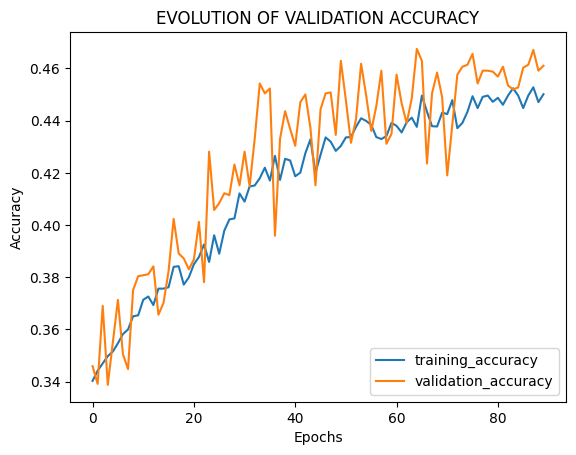

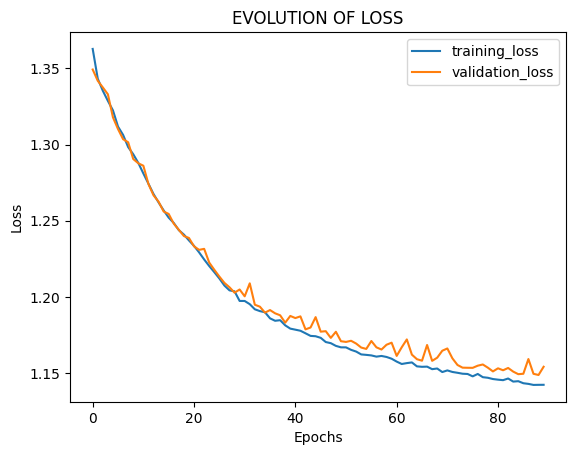

In [13]:
# Val acc. and Val loss evolution
plot_acc_loss(rn_model.fit)

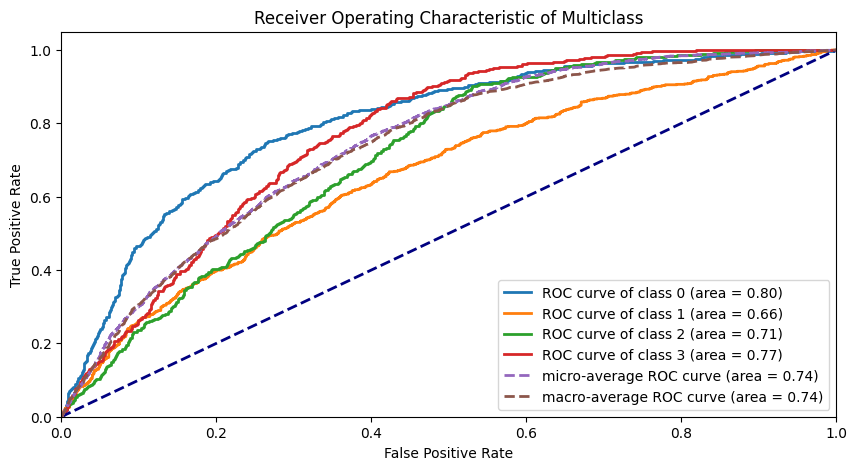

In [14]:
# ROC curves
plot_ROC(rn_model.predictions,basic_bundle.y_test_onehot,4)

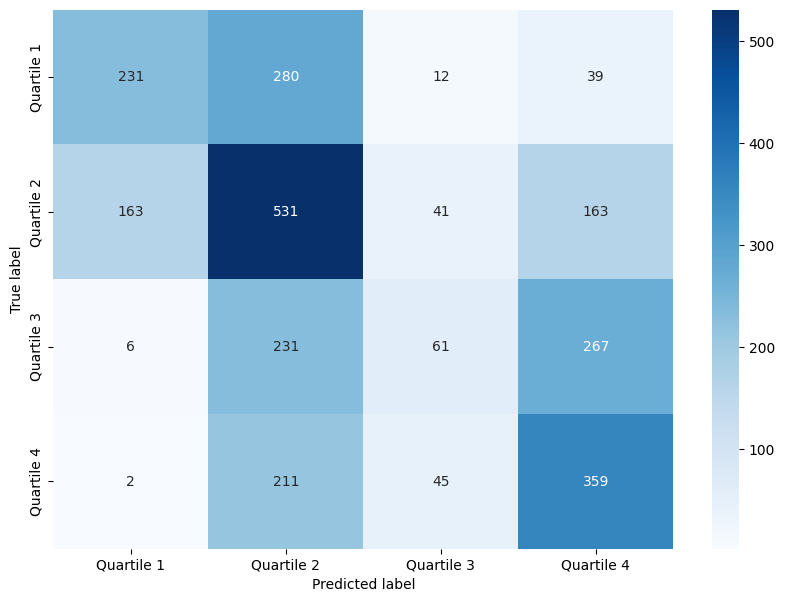

In [15]:
# Confusion matrix
plot_cm(basic_bundle.y_test_onehot,rn_model.predictions)

In [16]:
# Clasification report
print(classification_report(np.argmax(basic_bundle.y_test_onehot, axis=1), np.argmax(rn_model.predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48       562
           1       0.42      0.59      0.49       898
           2       0.38      0.11      0.17       565
           3       0.43      0.58      0.50       617

    accuracy                           0.45      2642
   macro avg       0.45      0.42      0.41      2642
weighted avg       0.45      0.45      0.42      2642



In [17]:
rn_model.save("/content/drive/MyDrive/Thesis/M224A-2111/rn50_gdp_224A_2111_v1.h5")